Попробуем поэксперементировать с трендом нового вида.

Напомним, что основная идея заключается в том, что в более богатом семействе тренд-функций можно достичь лучшей интерполяции тренда, а значит как улучшить прогноз самого тренда, так и улучшить прогноз остальных компонент (за счет более точного отделения тренда).
При этом мы усложняем модель, что может приводить к разного рода негативным эффектам (например переобучению).

Новый тренд является обобщением линейного и записывается в виде 

$s(t) = kt^{\alpha} + m$.

В процессе обучения происходит подбор параметра $\alpha$, при этом на него навешивается приор Лапласа с дисперсией по умолчанию 0.1, которую можно менять.

Для простоты мы считаем, что новый тренд также называется в коде linear, дисперсию приора можно задавать как alpha_prior_scale.

Загрузим оригинальные датасеты из бенчмарков.

In [1]:
import statsmodels
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import median_absolute_error
from sklearn.utils import check_array
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime
%matplotlib inline
plt.style.use('Solarize_Light2')

In [2]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
def MdAPE(y_true, y_pred): 
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def sMAPE(actual, predicted):
    return 100 * np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def sMdAPE(actual, predicted):
    return 100 * np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

def RMSPE(actual, predicted):
    return 100 * np.sqrt(np.mean(np.square((actual - predicted)/actual)))

def RMdSPE(actual: np.ndarray, predicted: np.ndarray):
    return 100 * np.sqrt(np.median(np.square((actual - predicted)/actual)))

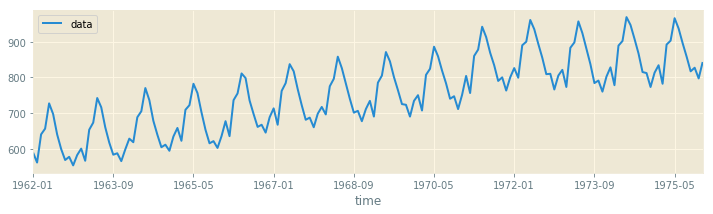

In [3]:
data = pd.read_csv("monthly-milk.csv", sep=";")[:-1]
data.columns = ['time','data']
df = data.set_index('time')
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));

In [4]:
data_aep = pd.read_csv('AEP_hourly.csv')
aep = pd.DataFrame(data_aep, columns=['Datetime','AEP_MW']).set_index('Datetime')
aep.sort_index(inplace=True)

In [5]:
aep = aep.iloc[115000:]

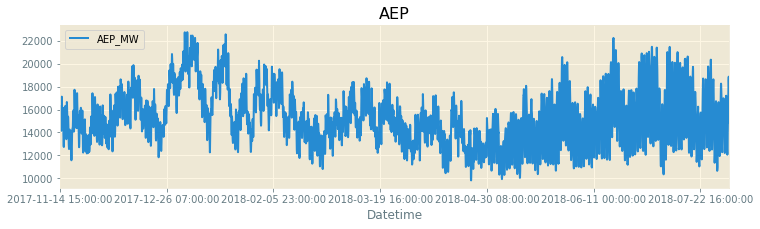

In [6]:
train_aep = aep.iloc[:-100, :]
test_aep = aep.iloc[-100:, :]
train_aep.index = pd.to_datetime(train_aep.index)
test_aep.index = pd.to_datetime(test_aep.index)
pred_aep = test_aep.copy()
aep.plot(figsize=(12,3));
plt.title('AEP');

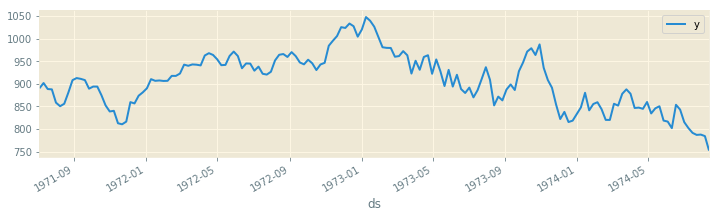

In [7]:
data_dj = pd.read_csv("DJ.csv", sep=";")[:-1]
data_dj.columns = ['ds_','y']
data_dj['ds'] = data_dj.reset_index().apply(lambda row: datetime.datetime.strptime(str(row['ds_']) + '-1', "%Y-W%W-%w"), axis=1)
data_dj = data_dj.drop(['ds_'], axis=1)
df_dj = data_dj.set_index('ds')
train_dj = df_dj.iloc[:-14, :]
test_dj = df_dj.iloc[-14:, :]
train_dj.index = pd.to_datetime(train_dj.index)
test_dj.index = pd.to_datetime(test_dj.index)
df_dj.plot(figsize=(12,3));

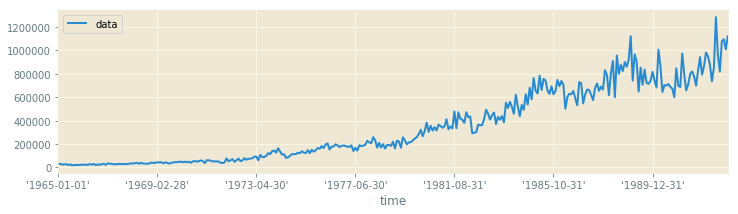

In [8]:
data_au = pd.read_csv("import.csv", sep=";")[:-1]
data_au.columns = ['time','data']
df_au = data_au.set_index('time')
train_au = df_au.iloc[:-12, :]
test_au = df_au.iloc[-12:, :]
pred_au = test_au.copy()
df_au.plot(figsize=(12,3));

Импортируем обычный fbprophet и новый prophet

In [9]:
from fbprophet import Prophet as Prophet_original
from trend_prophet import Prophet

**1. Milk Production**

In [10]:
train_fb = train.reset_index()
train_fb.columns = ['ds','y']

Проведем эксперименты с обычным профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [11]:
m = Prophet_original()
m.fit(train_fb)
future = m.make_future_dataframe(periods=24,freq='M')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-24:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-24:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-24:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-24:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))

/home/petr/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 6681.302218850347
RMSE, Test: 81.73923304540084
MAE, Test: 65.87173396485302
RMSLE, Test: 0.09431917393109336
MdAPE, Test: 1.6029665110658127
sMAPE, Test: 1.8474966223839397
sMdAPE, Test: 1.6159179352279494
RMSPE, Test: 2.289661913897465


In [12]:
m = Prophet_original(mcmc_samples=500)
m.fit(train_fb)
future = m.make_future_dataframe(periods=24,freq='M')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-24:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-24:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-24:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-24:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 6677.214019609619
RMSE, Test: 81.71422164843534
MAE, Test: 65.86436297903182
RMSLE, Test: 0.09430222903899488
MdAPE, Test: 1.6368145714328874
sMAPE, Test: 1.8740292775733847
sMdAPE, Test: 1.6503241446251842
RMSPE, Test: 2.311233785830499


Проведем эксперименты с новым профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [13]:
m = Prophet(linear_power_trend=True)
m.fit(train_fb)
future = m.make_future_dataframe(periods=24,freq='M')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-24:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-24:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-24:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-24:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 6713.902514485868
RMSE, Test: 81.93840683394978
MAE, Test: 66.07692508923768
RMSLE, Test: 0.09463247441319499
MdAPE, Test: 1.799081795597322
sMAPE, Test: 1.9773254670460354
sMdAPE, Test: 1.8154141123486636
RMSPE, Test: 2.380418004738243


In [14]:
m = Prophet(linear_power_trend=True, mcmc_samples=500)
m.fit(train_fb)
future = m.make_future_dataframe(periods=24,freq='M')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-24:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-24:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-24:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-24:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-24:].values.flatten()))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 6644.205301028604
RMSE, Test: 81.51199482915753
MAE, Test: 65.63184809851545
RMSLE, Test: 0.09395270925672328
MdAPE, Test: 1.3488786719537622
sMAPE, Test: 1.699124014814823
sMdAPE, Test: 1.3580593332079813
RMSPE, Test: 2.216716756958263


**2) AEP**

In [15]:
train_fb_aep = train_aep.reset_index()
train_fb_aep.columns = ['ds','y']

In [16]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2014-01-01','2015-01-01','2016-01-01', '2017-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2016-01-18', '2017-01-16'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2016-02-15', '2017-02-20'])})
mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2016-05-30', '2017-05-29'])})
ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2014-07-04','2015-07-04', '2016-07-04', '2017-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2015-09-07', '2016-09-05', '2017-09-04'])})
col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2015-10-12', '2016-10-10', '2017-10-09'])})
vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2014-11-11','2015-11-11', '2016-11-11', '2017-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2015-11-26', '2016-11-24'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2014-12-25','2015-12-25', '2016-12-25','2017-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

Проведем эксперименты с обычным профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [17]:
m_aep = Prophet_original(yearly_seasonality=True, weekly_seasonality=True,holidays=us_public_holidays)
m_aep.fit(train_fb_aep)
future = m_aep.make_future_dataframe(periods=100,freq='H')
forecast = m_aep.predict(future)
print('MSE, Test:', metrics.mse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSE, Test:', metrics.rmse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MAE, Test:', metrics.mae(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))

MSE, Test: 15008348.414001273
RMSE, Test: 3874.060971900323
MAE, Test: 3177.1015988761606
RMSLE, Test: 0.23817948500417527
MdAPE, Test: 16.574227593822236
sMAPE, Test: 16.593784629469237
sMdAPE, Test: 15.305740939365931
RMSPE, Test: 21.499552990593905


In [18]:
m_aep = Prophet_original(mcmc_samples=50, yearly_seasonality=True, weekly_seasonality=True,holidays=us_public_holidays)
m_aep.fit(train_fb_aep)
future = m_aep.make_future_dataframe(periods=100,freq='H')
forecast = m_aep.predict(future)
print('MSE, Test:', metrics.mse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSE, Test:', metrics.rmse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MAE, Test:', metrics.mae(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))

MSE, Test: 20751655.90671255
RMSE, Test: 4555.398545320985
MAE, Test: 3799.62958976103
RMSLE, Test: 0.2716518585566356
MdAPE, Test: 21.107434190459262
sMAPE, Test: 20.48697902602081
sMdAPE, Test: 19.092446789119276
RMSPE, Test: 26.72609391470705


Проведем эксперименты с новым профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [19]:
m_aep = Prophet(linear_power_trend=True, yearly_seasonality=True, weekly_seasonality=True,holidays=us_public_holidays)
m_aep.fit(train_fb_aep)
future = m_aep.make_future_dataframe(periods=100,freq='H')
forecast = m_aep.predict(future)
print('MSE, Test:', metrics.mse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSE, Test:', metrics.rmse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MAE, Test:', metrics.mae(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))

MSE, Test: 15773529.262889666
RMSE, Test: 3971.59026875755
MAE, Test: 3265.4558402601597
RMSLE, Test: 0.24306522881285378
MdAPE, Test: 17.307258065731723
sMAPE, Test: 17.185018114548505
sMdAPE, Test: 15.928819670797372
RMSPE, Test: 22.273795620946377


In [20]:
m_aep = Prophet(linear_power_trend=True, mcmc_samples=50, yearly_seasonality=True, weekly_seasonality=True,holidays=us_public_holidays)
m_aep.fit(train_fb_aep)
future = m_aep.make_future_dataframe(periods=100,freq='H')
forecast = m_aep.predict(future)
print('MSE, Test:', metrics.mse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSE, Test:', metrics.rmse(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MAE, Test:', metrics.mae(test_aep.values, forecast.yhat.iloc[-100:].values))
print('RMSLE, Test:', metrics.rmsle(test_aep.values, forecast.yhat.iloc[-100:].values))
print('MdAPE, Test:', MdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_aep.values.flatten(),forecast.yhat.iloc[-100:].values.flatten()))

MSE, Test: 19619744.187768016
RMSE, Test: 4429.418041658296
MAE, Test: 3674.582208313453
RMSLE, Test: 0.2653193713899063
MdAPE, Test: 19.86423571036119
sMAPE, Test: 19.634332806835502
sMdAPE, Test: 18.06954700246297
RMSPE, Test: 25.71566126146777


**3) DJIA**

In [21]:
train_fb_dj = train_dj.reset_index()
train_fb_dj.columns = ['ds','y']

Проведем эксперименты с обычным профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [22]:
m = Prophet_original(weekly_seasonality=True,yearly_seasonality=True,holidays=us_public_holidays)
m.fit(train_fb_dj)
future = m.make_future_dataframe(periods=14,freq='W')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSE, Test:', metrics.rmse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAE, Test:', metrics.mae(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 1051.95179003632
RMSE, Test: 32.43380628351104
MAE, Test: 26.632202882222735
RMSLE, Test: 0.040021164049318485
MdAPE, Test: 2.0906650355230427
sMAPE, Test: 2.3850160903602498
sMdAPE, Test: 2.093775037518444
RMSPE, Test: 2.8036082390159494


In [23]:
m = Prophet_original(mcmc_samples=20, weekly_seasonality=True,yearly_seasonality=True,holidays=us_public_holidays)
m.fit(train_fb_dj)
future = m.make_future_dataframe(periods=14,freq='W')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSE, Test:', metrics.rmse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAE, Test:', metrics.mae(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 460656.4707901852
RMSE, Test: 678.7167824580332
MAE, Test: 677.9438170946657
RMSLE, Test: 1.8119847211775235
MdAPE, Test: 83.25511322624936
sMAPE, Test: 143.67456538065707
sMdAPE, Test: 142.62759901129903
RMSPE, Test: 83.6004519076458


Проведем эксперименты с новым профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [24]:
m = Prophet(linear_power_trend=True, weekly_seasonality=True,yearly_seasonality=True,holidays=us_public_holidays)
m.fit(train_fb_dj)
future = m.make_future_dataframe(periods=14,freq='W')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSE, Test:', metrics.rmse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAE, Test:', metrics.mae(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 1051.992771360952
RMSE, Test: 32.43443804601757
MAE, Test: 26.63326653002099
RMSLE, Test: 0.040021801898870654
MdAPE, Test: 2.0888293806342486
sMAPE, Test: 2.386816397897347
sMdAPE, Test: 2.091999561562568
RMSPE, Test: 2.804580376031289


In [25]:
m = Prophet(linear_power_trend=True, mcmc_samples=20, weekly_seasonality=True,yearly_seasonality=True,holidays=us_public_holidays)
m.fit(train_fb_dj)
future = m.make_future_dataframe(periods=14,freq='W')
forecast = m.predict(future)
print('MSE, Test:', metrics.mse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSE, Test:', metrics.rmse(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MAE, Test:', metrics.mae(test_dj.values, forecast.yhat.iloc[-14:].values))
print('RMSLE, Test:', metrics.rmsle(test_dj.values, forecast.yhat.iloc[-14:].values))
print('MdAPE, Test:', MdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_dj.values.flatten(),forecast.yhat.iloc[-14:].values.flatten()))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 565859.750992934
RMSE, Test: 752.2364993756511
MAE, Test: 751.5251170686132
RMSLE, Test: 0.6568559906164575
MdAPE, Test: 93.7448252422892
sMAPE, Test: 63.3706407521492
sMdAPE, Test: 63.82688993685035
RMSPE, Test: 93.02895906933134


**4) Australian import**

In [26]:
train_fb_au = train_au.reset_index()
train_fb_au.columns = ['ds','y']
#train_fb_au['y'] = np.log(train_fb_au['y'])

Проведем эксперименты с обычным профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [27]:
m_au = Prophet_original(seasonality_mode = 'multiplicative',yearly_seasonality=True, )
m_au.fit(train_fb_au)
future = m_au.make_future_dataframe(periods=12,freq='M')
forecast = m_au.predict(future)
print('MSE, Test:', metrics.mse(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSE, Test:', metrics.rmse(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAE, Test:', metrics.mae(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, forecast.yhat.iloc[-12:].values))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 40281942919.77759
RMSE, Test: 200703.6195980969
MAE, Test: 159353.81637813518
RMSLE, Test: 0.21016365203086285
MdAPE, Test: 14.588071411078008
sMAPE, Test: 16.18115897180953
sMdAPE, Test: 15.780518673359095
RMSPE, Test: 17.727537231411898


In [28]:
m_au = Prophet_original(mcmc_samples=50, seasonality_mode = 'multiplicative',yearly_seasonality=True, )
m_au.fit(train_fb_au)
future = m_au.make_future_dataframe(periods=12,freq='M')
forecast = m_au.predict(future)
print('MSE, Test:', metrics.mse(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSE, Test:', metrics.rmse(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAE, Test:', metrics.mae(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, forecast.yhat.iloc[-12:].values))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 41709653244.75099
RMSE, Test: 204229.41327034897
MAE, Test: 162129.81529756266
RMSLE, Test: 0.21523191512728843
MdAPE, Test: 15.372304927442695
sMAPE, Test: 16.941345054467206
sMdAPE, Test: 16.692583408314995
RMSPE, Test: 18.382462893694242


Проведем эксперименты с новым профитом с режимом оптимизации MAPE и MCMC (оставив те же параметры, что и были в бенчмарках).

In [29]:
m_au = Prophet(linear_power_trend=True, seasonality_mode = 'multiplicative',yearly_seasonality=True, )
m_au.fit(train_fb_au)
future = m_au.make_future_dataframe(periods=12,freq='M')
forecast = m_au.predict(future)
print('MSE, Test:', metrics.mse(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSE, Test:', metrics.rmse(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAE, Test:', metrics.mae(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, forecast.yhat.iloc[-12:].values))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 42335642497.39178
RMSE, Test: 205756.2696429729
MAE, Test: 163542.21303319305
RMSLE, Test: 0.21662733169639292
MdAPE, Test: 15.538685445628985
sMAPE, Test: 17.020418287922865
sMdAPE, Test: 16.891369855819082
RMSPE, Test: 18.345191991890946


In [30]:
m_au = Prophet(linear_power_trend=True, mcmc_samples=50, seasonality_mode = 'multiplicative',yearly_seasonality=True, )
m_au.fit(train_fb_au)
future = m_au.make_future_dataframe(periods=12,freq='M')
forecast = m_au.predict(future)
print('MSE, Test:', metrics.mse(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSE, Test:', metrics.rmse(test_au.values, forecast.yhat.iloc[-12:].values))
print('MAE, Test:', metrics.mae(test_au.values, forecast.yhat.iloc[-12:].values))
print('RMSLE, Test:', metrics.rmsle(test_au.values, forecast.yhat.iloc[-12:].values))
print('MdAPE, Test:', MdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMAPE, Test:', sMAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))
print('RMSPE, Test:', RMSPE(test_au.values.flatten(),forecast.yhat.iloc[-12:].values.flatten()))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE, Test: 38647838422.92344
RMSE, Test: 196590.5349271003
MAE, Test: 155688.58277777644
RMSLE, Test: 0.20606731429870928
MdAPE, Test: 13.936947247756514
sMAPE, Test: 15.96100895373839
sMdAPE, Test: 15.048133440831066
RMSPE, Test: 18.0645271070897


Как мы видим, результаты по MAP везде по большинству метрик оказались чуть лучше в оригинальном профите.
Однако по MCMC везде результаты оказались лучше у улучшенного профита и для 3 из 4 датасетов (кроме DJ) этот результат оказался самым лучшим вообще, то есть улучшенный профит дал лучшие результаты.

Кроме того, улучшенный профит дает очевидно более хорошие результаты на некоторых синтетических датасетах.

Например:

In [31]:
data = pd.DataFrame()
data["ds"] = pd.date_range(pd.datetime.today(), periods=4000)
data["y"] = ((0.01 * np.arange(1, 4001)) ** 2) * (1 + np.sin(2 * np.pi * np.arange(1, 4001) / 365))
train = data[:3500]
test  = data[3500:]["y"]я
plt.plot(data["y"])

SyntaxError: invalid syntax (<ipython-input-31-9948173a27ad>, line 5)

Проведем эксперименты с обычным профитом с режимом оптимизации MAPE и MCMC.

In [ ]:
m = Prophet_original(seasonality_mode = 'multiplicative',yearly_seasonality=True,
                     daily_seasonality=False,  weekly_seasonality=False)
m.fit(train)
forecast = m.predict(data)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-500:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-500:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-500:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-500:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))

In [ ]:
m = Prophet_original(mcmc_samples=50, seasonality_mode = 'multiplicative',yearly_seasonality=True,
                     daily_seasonality=False,  weekly_seasonality=False)
m.fit(train)
forecast = m.predict(data)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-500:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-500:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-500:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-500:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))

Проведем эксперименты с новым профитом с режимом оптимизации MAPE и MCMC

In [ ]:
m = Prophet(linear_power_trend=True, seasonality_mode = 'multiplicative',yearly_seasonality=True,
            daily_seasonality=False,  weekly_seasonality=False, alpha_prior_scale=1)
m.fit(train)
forecast = m.predict(data)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-500:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-500:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-500:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-500:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))

In [ ]:
m = Prophet(linear_power_trend=True, mcmc_samples=50, seasonality_mode = 'multiplicative',yearly_seasonality=True,
                     daily_seasonality=False, weekly_seasonality=False, alpha_prior_scale=1)
m.fit(train)
forecast = m.predict(data)
print('MSE, Test:', metrics.mse(test.values, forecast.yhat.iloc[-500:].values))
print('RMSE, Test:', metrics.rmse(test.values, forecast.yhat.iloc[-500:].values))
print('MAE, Test:', metrics.mae(test.values, forecast.yhat.iloc[-500:].values))
print('RMSLE, Test:', metrics.rmsle(test.values, forecast.yhat.iloc[-500:].values))
print('MdAPE, Test:', MdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMAPE, Test:', sMAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('sMdAPE, Test:', sMdAPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))
print('RMSPE, Test:', RMSPE(test.values.flatten(),forecast.yhat.iloc[-500:].values.flatten()))